In [1]:
from somefunctions import *
augmented = False

C:\Users\nicol\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Configuration parameters
Easier if we put them all togheter

In [2]:
reg = 1e-6  #regularization term
pool_size = (2, 2)
train_shape = 400 #size of the training images
patch_size = 16
input_size = 80 # for now is the patch size
pad_size = int(input_size/2 - patch_size/2)
batch_size = 100
learning_rate = 0.001


nb_epoch = 2 #very small, only preliminary tests
steps_per_epoch = 10 #the number of training samples is huge, arbitrary value
        

# Function to generate the minibatch
This function will be called during the training. <br>
Here we can also do some feature augmentation, for example. But maybe is more efficient to flip all the images before. <br>
TODO: take a random patch of dimension (input_size x input_size)

In [3]:
def generate_minibatch(X,Y):
    """
    Generate a minibatch
    """
    while 1:
        # Generate one minibatch
        X_batch = np.empty((batch_size, input_size, input_size, 3))
        Y_batch = np.empty(batch_size)
        low=input_size//2
        high = (train_shape + 2*pad_size - input_size//2)
        for i in range(batch_size):
            # Select a random image
            idx = np.random.choice(X.shape[0])
            
            x_coord = np.random.randint(low=low, high = high ) 
            y_coord = np.random.randint(low=low, high = high )
      
            X_batch[i] = X[idx,x_coord - input_size//2:x_coord + input_size//2,y_coord - input_size//2:y_coord + input_size//2]
            
            gt_batch = Y[idx,x_coord - patch_size//2:x_coord + patch_size//2,y_coord - patch_size//2:y_coord + patch_size//2]            
            Y_batch[i] = patch_to_label(gt_batch)
            
            #TODO: TRY TO CHANGE CONTRAST AND BRIGHTNESS
            
            
        yield X_batch, Y_batch

In [4]:
np.random.choice(4)

0

# Train
Generate the model and train the dataset

In [5]:
def train(X, Y):    
    '''
    Generate an instance of the model an train the model on X, Y
    '''
    print('Training set shape: ', X.shape) 
    print(f'Batch_size: {batch_size} \nSteps per epoch: {steps_per_epoch} \n')
    
    
    model = Sequential()
    model.add(Convolution2D(64, kernel_size=(5, 5), 
                            input_shape = ( input_size, input_size, 3), 
                            activation = 'relu',
                            padding = 'SAME'))
    model.add(Flatten())
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    
    
        
    opt = Adam(lr=learning_rate) # Adam optimizer with default initial learning rate
 

    # This callback reduces the learning rate when the training accuracy does not improve any more
    lr_callback = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=5,
                                    verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    # Stops the training process upon convergence
    stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=11, verbose=1, mode='auto')
    
    model.compile(loss=binary_crossentropy,
                  optimizer=opt,
                  metrics=['acc'])
    
    np.random.seed(20122018) # Reproducibility + remember the deadline is the 20.12.2018
    
    model.fit_generator(generate_minibatch(X,Y),
                        steps_per_epoch=steps_per_epoch,
                        nb_epoch=nb_epoch,
                        verbose=1,
                        callbacks=[lr_callback, stop_callback])

    print('Training completed')
    
    model.save_weights('pesi')
    
    return model

# Load images

In [6]:
# Load a set of image
root_dir = "../Data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) 
print("Loading " + str(n) + " images")
imgs_original = [load_image(image_dir + files[i]) for i in range(n)]
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])




Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


# Preprocessing

In [7]:
#augmenting
if not augmented:
    #flip
    for i in range(n):
        imgs.append(np.fliplr(imgs[i]))
        imgs.append(np.flipud(imgs[i]))
        gt_imgs.append(np.fliplr(gt_imgs[i]))
        gt_imgs.append(np.flipud(gt_imgs[i]))
    
    #rotate
    for i in range(3*n):
        imgs.append(np.rot90(imgs[i],1))
        imgs.append(np.rot90(imgs[i],2))
        imgs.append(np.rot90(imgs[i],3))
        gt_imgs.append(np.rot90(gt_imgs[i],1))
        gt_imgs.append(np.rot90(gt_imgs[i],2))
        gt_imgs.append(np.rot90(gt_imgs[i],3))
        
    augmented = True
        

imgs = padding_imgs(np.array(imgs),pad_size)
gt_imgs = padding_GT(np.array(gt_imgs),pad_size)



# Training

# split in validation + train

(VERY BASIC!) In this way we can check directly what happens in the validation set

In [8]:
N = imgs.shape[0]
ratio = 0.8
N_train = int(N*ratio)
N_valid = int(N - N*ratio)
X_train = imgs[:N_train]
X_valid = imgs[N-N_valid:]
Y_train = gt_imgs[:N_train]
Y_valid = gt_imgs[N-N_valid:]

In [9]:
print(X_train.shape)
print(X_valid.shape)
print(X_train.shape[0] + X_valid.shape[0])

(960, 464, 464, 3)
(240, 464, 464, 3)
1200


In [10]:
model = train(X_train,Y_train)

Training set shape:  (960, 464, 464, 3)
Batch_size: 100 
Steps per epoch: 10 



C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=10, verbose=1, callbacks=[<keras.ca..., epochs=2)`


Epoch 1/2
10/10 [==============================] - 32s 3s/step - loss: 3.7264 - acc: 0.7440
Epoch 2/2
10/10 [==============================] - 22s 2s/step - loss: 3.9973 - acc: 0.7520
Training completed


# Check if on the train set we have good results

In [11]:
def imgs_to_windows(imgs, img_size, patch_size, window_size):
    ''' Takes padded images and outputs an array with the windows'''
    windows = []
    for idx in range(imgs.shape[0]):
        im = imgs[idx]
        for i in range(img_size//patch_size):
            for j in range(img_size//patch_size):
                temp = im[i*patch_size:window_size + i*patch_size,
                                  j*patch_size:window_size + j*patch_size]
                windows.append(temp)
    return np.asarray(windows)

In [23]:
def MY_label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgwidth,w):
        for j in range(0,imgheight,h):
            im[i:i+w, j:j+h] = labels[idx]
            idx = idx + 1
    return im

In [20]:
IDX = 0
X = imgs_to_windows(imgs[1:3],400,patch_size,input_size)
patches_idx = X[625*IDX:625*(IDX+1)]

patches_idx.shape


(625, 80, 80, 3)

In [24]:
Z_idx = model.predict(patches_idx)
labels_idx = (Z_idx > 0.5) *1 
predicted_image = MY_label_to_img(400,400,16,16,labels_idx)
    

C:\Users\nicol\Desktop\ML_project_2\src\somefunctions.py:25: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)


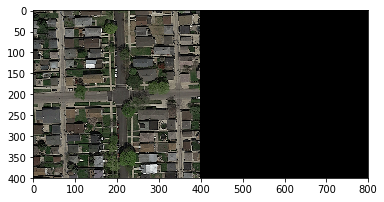

In [31]:
plt.imshow(concatenate_images(imgs_original[IDX],predicted_image))

# Check what happened on the validation

In [ ]:
X_valid
N_valid
labels_valid
Z_valid = model.predict(X_valid)

In [ ]:
Z_valid = ((Z_valid < 0.5) * 1).reshape(N_valid)
accuracy_valid = np.sum(np.abs(Z_valid - label_valid))/N_valid
print(accuracy_valid)

In [ ]:
from sklearn.metrics import f1_score
f1_score(Y_valid,Z_valid)

# predict on test

In [ ]:
test_images = pick_test_images()

print(np.array(test_images).shape)

n_test = len(test_images)

test_patches = [img_crop(test_images[i], patch_size, patch_size) for i in range(n_test)]

test_patches = np.asarray([test_patches[i][j] for i in range(len(test_patches)) for j in range(len(test_patches[i]))])

In [ ]:
Z = model.predict(test_patches)

In [ ]:
labels1D = (Z < 0.5 ) * 1
labels1D.shape
labels = labels1D.reshape(50,-1)
print(labels.shape)

In [ ]:
IDX = 9
im = label_to_img(608, 608, 16, 16, labels[IDX])
plt.imshow(concatenate_images(test_images[IDX], im))

In [ ]:
MY_masks_to_submission('dummsdsy_submission.csv', labels)